In [27]:
# Example code for reading the data and the initial weights and biases.
# Note: This is just an example of how to read these files, you can modify the code in your own implementation.

import numpy as np
import random

train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


checkpoint = np.load('weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:
    print(w.shape)
    

print()

print('shape of biases:')
for b in init_biases:
    
    print(b.shape)

shape of data:
(4500, 784)
(4500,)
(500, 784)
(500,)
shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


In [28]:
train_x = train_x/255.
test_x = test_x/255.

In [29]:
number_of_layers= 3
number_of_neurons = 2048, 512, 5
#activation function for each layer (in order): relu, relu, softmax
epochs= 30
learning_rate= 0.01
batch_size= 200


1.(a)

In [30]:
num_samples = train_x.shape[0]

In [31]:
num_batches = int((num_samples / batch_size))
batchX = np.array_split(train_x[:num_batches*batch_size], num_batches)
batchY = np.array_split(train_y[:num_batches*batch_size], num_batches)

In [32]:
batchX.append(train_x[num_batches*batch_size:])
batchY.append(train_y[num_batches*batch_size:])
num_batches=num_batches+1

In [33]:
def ReLU(array): #if x<0 y=0 ; if x>0 y=x 
    #value=np.multiply( np.add(array,np.abs(array)),0.5 )
    return np.maximum(0, array)#value
def softmax_cross_entropy(z,y):
    m=len(z)
    f=Softmax(z)
    loss=-np.sum(y*np.log(f+ 1e-99))/m
    return loss
def Softmax(array): #e^x/sum(e^x)
    a=np.max(array,axis=-1,keepdims=True)
    e_x=np.exp(array-a)
    return e_x/np.sum(e_x,axis=-1,keepdims=True)
    
def cross_entropy_grad(z,y):
    f=Softmax(z)
    dz=(f-y)/len(z)
    return dz 
def D_ReLU(array): #if x<0 y=0 ; if x>0 y=1 
    # value=np.multiply( np.add(array,np.abs(array)),0.5 )
    # value=np.multiply(value,np.reciprocal(array+1e-7))
    return np.where(array > 0, 1, 0)# value
def Onehot_encode(Y, k):
    Y = Y.astype(int)
    one_hot = np.eye(k)[Y]
    return one_hot

In [34]:
for i in range(3):
    init_biases[i]=init_biases[i].reshape((1,init_biases[i].shape[0] ))

In [35]:
init_weights_copy1=[w.copy() for w in init_weights]
init_biases_copy1=[b.copy() for b in init_biases]
init_weights_copy2=[w.copy() for w in init_weights]
init_biases_copy2=[b.copy() for b in init_biases]
init_weights_copy3=[w.copy() for w in init_weights]
init_biases_copy3=[b.copy() for b in init_biases]

In [36]:
def train(loss_list,acc_list,acc_test_list,loss_test_list,it,weights,biases,dropout=False,reshuffle=False,batchX=batchX,batchY=batchY,train_x=train_x,train_y=train_y):
    if reshuffle==True:
        random.seed(42)
        idx=list(range(4500))
        random.shuffle(idx)
        train_x = train_x[idx]
        train_y = train_y[idx]

        batchX = np.array_split(train_x[:num_batches*batch_size], num_batches)
        batchY= np.array_split(train_y[:num_batches*batch_size], num_batches)
    for i in range(num_batches):
        if not batchY[i].shape[-1]==5:
            batchY[i]=Onehot_encode(batchY[i],5)
        #print(batchY[i].shape)
        # Forward propagation
        
        z1=np.dot(batchX[i],weights[0])+biases[0]#200x2048
        a1=ReLU(z1)
        if dropout==True:
            one_zero=np.random.binomial(1, 0.8, size=a1.shape) /0.8
            a1=a1*one_zero
        z2=np.dot(a1,weights[1])+biases[1]#200x512
       
        a2=ReLU(z2)
        if dropout==True:
            one_zero=np.random.binomial(1, 0.8, size=a2.shape) /0.8
            a2=a2*one_zero
        z3=np.dot(a2,weights[2])+biases[2]#200x5
        
        loss=softmax_cross_entropy(z3,batchY[i])

        acc=sum(np.argmax(Softmax(z3),axis=-1)==np.argmax(batchY[i],axis=-1))/batchX[i].shape[0]

        
        loss_list.append(loss)
        acc_list.append(acc)
        

        
        # Backpropagation


        dz3=cross_entropy_grad(z3,batchY[i])
        dw3=np.dot(a2.T,dz3)
        db3=np.sum(dz3,axis=0,keepdims=True)
        da2=np.dot(dz3,weights[2].T)
        # if dropout==True:
        #     one_zero=np.random.binomial(1, 0.2, size=da2.shape) /0.8
        #     da2 = np.multiply(da2, one_zero)
        dz2=np.multiply(da2,D_ReLU(a2))
        dw2=np.dot(a1.T,dz2)
        db2=np.sum(dz2,axis=0,keepdims=True)
        da1=np.dot(dz2,weights[1].T)
        # if dropout==True:
        #     one_zero=np.random.binomial(1, 0.2, size=da1.shape) /0.8
        #     da1 = np.multiply(da1, one_zero)
        dz1=np.multiply(da1,D_ReLU(a1))
        dw1=np.dot(batchX[i].T,dz1)
        db1=np.sum(dz1,axis=0,keepdims=True)

        weights[0]+= -learning_rate*dw1
        biases[0]+= -learning_rate*db1
        weights[1]+= -learning_rate*dw2
        biases[1]+= -learning_rate*db2
        weights[2]+= -learning_rate*dw3
        biases[2]+= -learning_rate*db3
        
        test(acc_test_list,loss_test_list,weights,biases)

# Validate
def test(acc_test_list,loss_test_list,weights,biases,test_x=test_x,test_y=test_y):
    test_size = test_x.shape[0]#500

    # Forward propagation

    z1=np.dot(test_x,weights[0])+biases[0]#500x2048
    a1=ReLU(z1)
    z2=np.dot(a1,weights[1])+biases[1]#500x512
    a2=ReLU(z2)
    z3=np.dot(a2,weights[2])+biases[2]#500x5
    output=Softmax(z3)
    #print(output.shape)
    loss_test=softmax_cross_entropy(z3,Onehot_encode(test_y,5))
    # Result
    predict = np.argmax(output, axis=1)
    #print(predict)
    #print(answer)
    accuarcy_test = np.sum(np.equal(predict, test_y)/test_size)
    acc_test_list.append(accuarcy_test)
    loss_test_list.append(loss_test)
    # print("Accuarcy: %f "%accuarcy)

In [37]:
loss_list=[]
acc_list=[]
loss_test_list=[]
acc_test_list=[]
for it in range(epochs):
    print(it)
    train(loss_list,acc_list,acc_test_list,loss_test_list,it,weights=init_weights_copy1,biases=init_biases_copy1)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


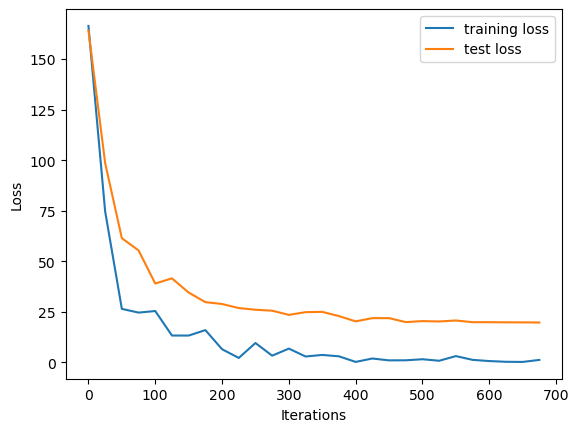

In [38]:
import matplotlib.pyplot as plt

x = [i*25 for i in range(len(loss_list[::25]))]
y = loss_list[::25]
y_test=loss_test_list[::25]
plt.plot(x, y,label='training loss')
plt.plot(x, y_test, label='test loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

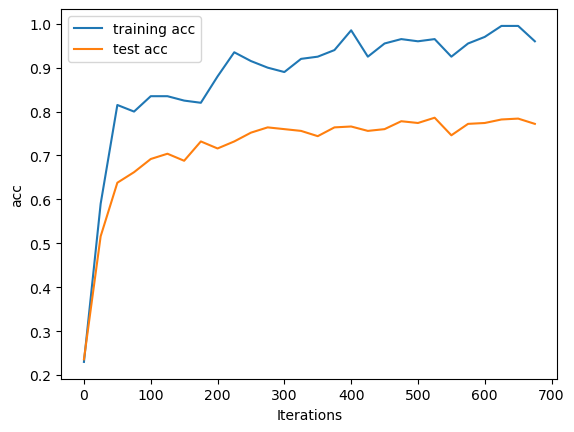

In [39]:
x = [i*25 for i in range(len(acc_list[::25]))]
y = acc_list[::25]
y_test=acc_test_list[::25]
plt.plot(x, y, label='training acc')
plt.plot(x, y_test, label='test acc')
plt.xlabel('Iterations')
plt.ylabel('acc')
plt.legend()
plt.show()

In [40]:
print(f'final training loss: {loss_list[-1]:.2f}')
print(f'final test loss: {loss_test_list[-1]:.2f}')
print(f'final training acc: {acc_list[-1]:.2f}')
print(f'final test acc: {acc_test_list[-1]:.2f}')

final training loss: 0.75
final test loss: 19.27
final training acc: 0.96
final test acc: 0.78


1.(b)

In [41]:
zeros_weights=[np.zeros((784,2048)),np.zeros((2048,512)),np.zeros((512,5))]
zeros_biases=[np.zeros((1,2048)),np.zeros((1,512)),np.zeros((1,5))]

In [42]:
loss_list=[]
acc_list=[]
loss_test_list=[]
acc_test_list=[]
for it in range(epochs):
    print(it)
    train(loss_list,acc_list,acc_test_list,loss_test_list,it,weights=zeros_weights,biases=zeros_biases)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


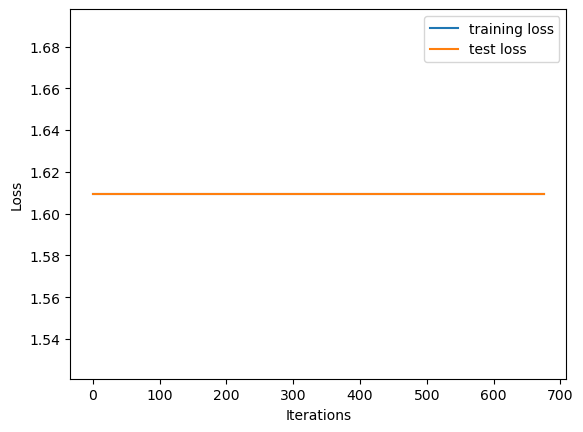

In [43]:
x = [i*25 for i in range(len(loss_list[::25]))]
y = loss_list[::25]
y_test=loss_test_list[::25]
plt.plot(x, y,label='training loss')
plt.plot(x, y_test, label='test loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

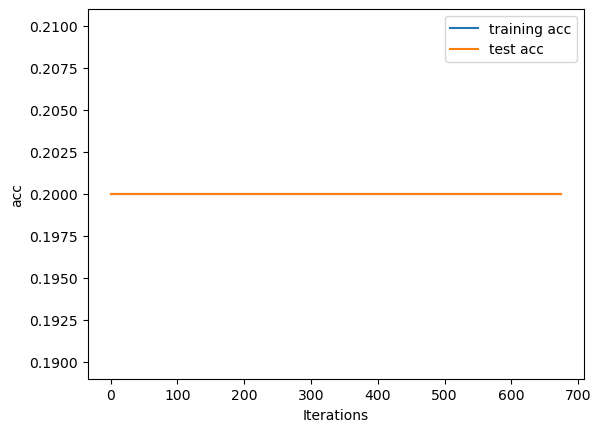

In [44]:
x = [i*25 for i in range(len(acc_list[::25]))]
y = acc_list[::25]
y_test=acc_test_list[::25]
plt.plot(x, y, label='training acc')
plt.plot(x, y_test, label='test acc')
plt.xlabel('Iterations')
plt.ylabel('acc')
plt.legend()
plt.show()

In [45]:
print(f'final training loss: {loss_list[-1]:.2f}')
print(f'final test loss: {loss_test_list[-1]:.2f}')
print(f'final training acc: {acc_list[-1]:.2f}')
print(f'final test acc: {acc_test_list[-1]:.2f}')

final training loss: 1.61
final test loss: 1.61
final training acc: 0.20
final test acc: 0.20


可以看出來如果模型初始參數都是0，模型輸出會是0，梯度會消失，造成參數無法更新，loss無法下降，acc無法上升。

2.(a)

In [46]:
loss_list=[]
acc_list=[]
loss_test_list=[]
acc_test_list=[]
for it in range(epochs):
    print(it)
    train(loss_list,acc_list,acc_test_list,loss_test_list,it,weights=init_weights_copy2,biases=init_biases_copy2,dropout=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


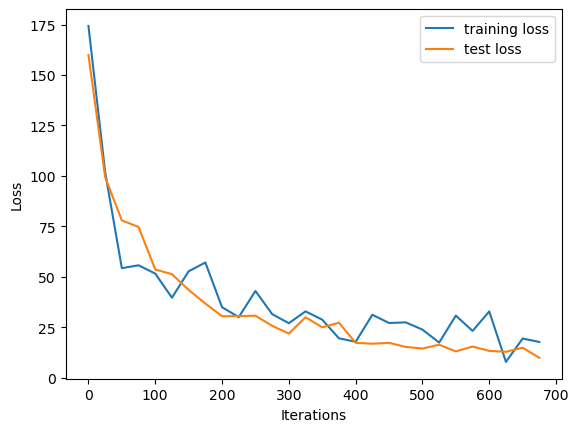

In [47]:
x = [i*25 for i in range(len(loss_list[::25]))]
y = loss_list[::25]
y_test=loss_test_list[::25]
plt.plot(x, y,label='training loss')
plt.plot(x, y_test, label='test loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

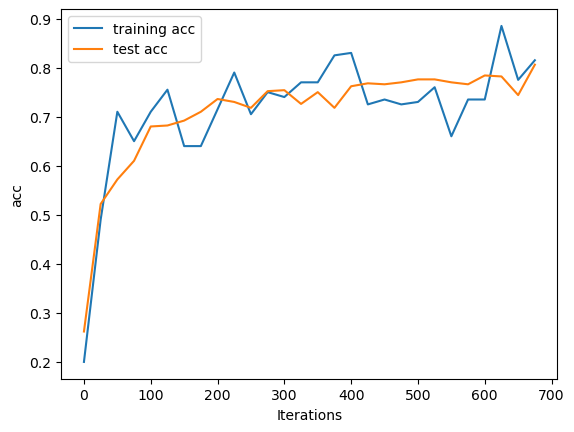

In [48]:
x = [i*25 for i in range(len(acc_list[::25]))]
y = acc_list[::25]
y_test=acc_test_list[::25]
plt.plot(x, y, label='training acc')
plt.plot(x, y_test, label='test acc')
plt.xlabel('Iterations')
plt.ylabel('acc')
plt.legend()
plt.show()

In [49]:
print(f'final training loss: {loss_list[-1]:.2f}')
print(f'final test loss: {loss_test_list[-1]:.2f}')
print(f'final training acc: {acc_list[-1]:.2f}')
print(f'final test acc: {acc_test_list[-1]:.2f}')

final training loss: 17.98
final test loss: 11.22
final training acc: 0.78
final test acc: 0.79


2.(b)

可以看出來加了dropout，overfitting的情況減緩了。因為如果模型參數太多，訓練資料太少，很容易產生overfitting，這時讓一些神經元變成0，可以減緩overfitting情況，增加模型性能。

3.(a)

In [50]:
loss_list=[]
acc_list=[]
loss_test_list=[]
acc_test_list=[]
for it in range(epochs):
    print(it)
    train(loss_list,acc_list,acc_test_list,loss_test_list,it,weights=init_weights_copy3,biases=init_biases_copy3,reshuffle=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


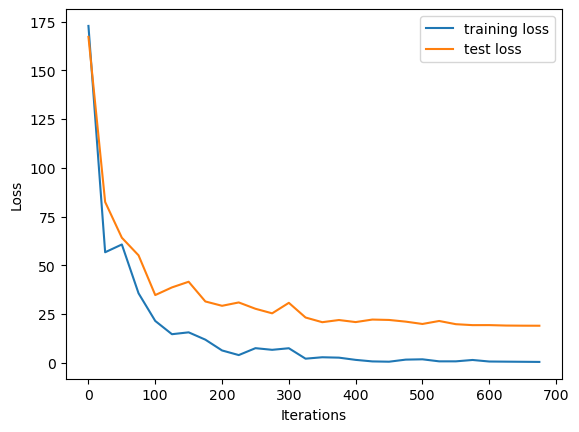

In [51]:
x = [i*25 for i in range(len(loss_list[::25]))]
y = loss_list[::25]
y_test=loss_test_list[::25]
plt.plot(x, y,label='training loss')
plt.plot(x, y_test, label='test loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

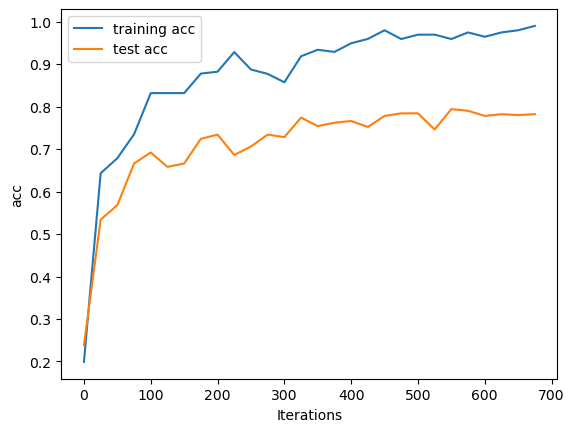

In [52]:
x = [i*25 for i in range(len(acc_list[::25]))]
y = acc_list[::25]
y_test=acc_test_list[::25]
plt.plot(x, y, label='training acc')
plt.plot(x, y_test, label='test acc')
plt.xlabel('Iterations')
plt.ylabel('acc')
plt.legend()
plt.show()

In [53]:
print(f'final training loss: {loss_list[-1]:.2f}')
print(f'final test loss: {loss_test_list[-1]:.2f}')
print(f'final training acc: {acc_list[-1]:.2f}')
print(f'final test acc: {acc_test_list[-1]:.2f}')

final training loss: 0.05
final test loss: 18.95
final training acc: 0.99
final test acc: 0.80


3.(b)

可以看出來讓訓練資料進行reshuffle，overfitting的情況減緩了。因為每個epoch的訓練資料順序都不同，可以讓模型學到更多資訊。